In [1]:
# Installing dependencies
"""
! pip install numpy
! pip install pandas
! pip install nltk
! pip install keras
! pip install matplotlib
! pip install sklearn
! pip install plotly
! pip install gensim
"""

'\n! pip install numpy\n! pip install pandas\n! pip install nltk\n! pip install keras\n! pip install matplotlib\n! pip install sklearn\n! pip install plotly\n! pip install gensim\n'

In [14]:
# Importing libraries
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline 

from scipy import stats

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input, merge, concatenate
from keras.layers.embeddings import Embedding
from keras.utils.np_utils import to_categorical
from keras.models import Model,load_model

from scipy.stats.kde import gaussian_kde
from numpy import linspace
import inspect

from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /home/vageesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Pre-processing of data

In [15]:
# Loading dataset
df = pd.read_hdf("weebit.h5","text_df")[['text','y']]
# Dropping null values
df.dropna(inplace=True)
# Converting class labels to int dtype
df['y'] = df['y'].astype(int)
print("Shape of the dataset:",df.shape)

Shape of the dataset: (7349, 2)


In [16]:
# Cleaning the text data
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("german"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)  
    text = text.split()
    stemmer = SnowballStemmer('german')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [17]:
df['text'] = df['text'].map(lambda x: clean_text(x))
df.head()

,text,y
0,your web brows does not hav javascript switche...,4
2,the most radical chang styl for women's clothi...,4
5,'i'v mad out will; i'v left myself'+'i'v mad o...,4
6,kennedy announc naval blockad cuba. b52 nuclea...,4
7,compar what jennif and michael said this rol p...,4


In [18]:
# Because of the computational expenses, I am using the top 20000 unique words. 
# At first, the text is tokenized and then convert those into sequences. 
# I have kept 50 words to limit the number of words in each comment.
vocabulary_size = 20000

# Initializing Tokenizer from keras
tokenizer = Tokenizer(num_words= vocabulary_size)
# Fitting text on the tokenizer
tokenizer.fit_on_texts(df['text'])
# Converting text to sequence
sequences = tokenizer.texts_to_sequences(df['text'])

# Finding unique tokenizer
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Padding sequences to the length of MAX_SEQUENCE_LENGTH
data = pad_sequences(sequences, maxlen=50)
labels = df['y']

Found 37271 unique tokens.


# Visualizing data

In [19]:
unique_class_labels = df['y'].unique()
print("class labels from the corpora:",unique_class_labels)

class labels from the corpora: [4 2 1 0 3]


In [20]:
# Used to modify elements of a dictionary
class make_dict(dict):
    def __getitem__(self, item):
        try:
            return dict.__getitem__(self, item)
        except KeyError:
            value = self[item] = type(self)()
            return value

In [21]:
# Printing the total number of sentences in the corpora
print("Total no of sentences in the Corpora is",df.shape[0])
# Getting count of sentences for every class
count_list = []
for class_label in df['y'].unique():
    print("No of sentences in class label",str(class_label) + " is " + str(df[df['y']==class_label].shape[0]))
    count_list.append((str(class_label),int(df[df['y']==class_label].shape[0])))

Total no of sentences in the Corpora is 7349
No of sentences in class label 4 is 4525
No of sentences in class label 2 is 798
No of sentences in class label 1 is 788
No of sentences in class label 0 is 607
No of sentences in class label 3 is 631


In [22]:
# Getting data into dictionary for plotting
no_of_sentence = make_dict()
for values in count_list:
    no_of_sentence[values[0]] = values[1]

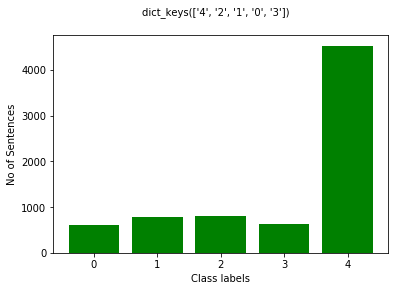

In [23]:
plt.bar(list(no_of_sentence.keys()), no_of_sentence.values(), color='g')
plt.suptitle(no_of_sentence.keys(), fontsize=10)
plt.xlabel('Class labels', fontsize=10)
plt.ylabel('No of Sentences', fontsize=10)
plt.show()

# Splitting the training and testing data

In [24]:
# Getting the labels and features data
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (7349, 50)
Shape of label tensor: (7349, 5)


In [25]:
# Getting the splitting index for training and testing data
SPLIT_RATIO = 0.25
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
validation_samples = int(SPLIT_RATIO * data.shape[0])

In [26]:
# Getting the testing and training dataset
X_train = data[:-validation_samples]
y_train = labels[:-validation_samples]
X_test = data[-validation_samples:]
y_test = labels[-validation_samples:]

# Text Classification using Using Convolutional neural network with multiple filter sizes(Deutsche lernen accuracy = 98.16%,Weebit Corpus accuracy=58.02-77.35%,GEO Corpus accuracy=86.84%)
# (https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf)

The network starts with an embedding layer. The layer lets the system expand each token to a more massive vector, allowing the network to represent a word in a meaningful way. The layer takes 20000 as the first argument, which is the size of our vocabulary, and 100 as the second input parameter, which is the dimension of the embeddings. The third parameter is the input_length of 50, which is the length of each text sequence.

In [343]:
# defining the globals
max_input_length = 50
vocabulary_size = 20000
embedding_dim = 100

In [344]:
filter_sizes = (2,4,5,8)
dropout_prob = [0.4,0.5]

In [345]:
# Setting the Convolution layer
graph_in = Input(shape=(max_input_length, embedding_dim))
convs = []
avgs = []

for fsz in filter_sizes:
    conv = Conv1D(nb_filter=32,filter_length=fsz,border_mode='valid',activation='relu',subsample_length=1)(graph_in)
    pool = MaxPooling1D(pool_length = max_input_length - fsz + 1)(conv)
    flattenMax = Flatten()(pool)
    convs.append(flattenMax)

if len(filter_sizes)>1:
    out = concatenate(convs,axis=-1)
else:
    out = convs[0]

graph = Model(input=graph_in, output=out, name="graphModel")

In [379]:
# Un-comment the below mentioned code to train your model

# Configuring the neural network
"""model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocabulary_size, output_dim = embedding_dim,input_length = max_input_length,trainable=True))
model_cnn.add(Dropout(dropout_prob[0]))
model_cnn.add(graph)
model_cnn.add(Dense(256))
model_cnn.add(Dropout(dropout_prob[1]))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(y_train.shape[1]))
model_cnn.add(Activation('softmax'))
model_cnn.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print("model fitting - CNN network")
model_cnn.summary()
# Training the model
model_cnn.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10)
# Saving the model
model_cnn.save("simple_cnn.h5")"""

'model_cnn = Sequential()\nmodel_cnn.add(Embedding(input_dim=vocabulary_size, output_dim = embedding_dim,input_length = max_input_length,trainable=True))\nmodel_cnn.add(Dropout(dropout_prob[0]))\nmodel_cnn.add(graph)\nmodel_cnn.add(Dense(256))\nmodel_cnn.add(Dropout(dropout_prob[1]))\nmodel_cnn.add(Activation(\'relu\'))\nmodel_cnn.add(Dense(y_train.shape[1]))\nmodel_cnn.add(Activation(\'softmax\'))\nmodel_cnn.compile(loss=\'categorical_crossentropy\',optimizer=\'rmsprop\',metrics=[\'accuracy\'])\nprint("model fitting - CNN network")\nmodel_cnn.summary()\n# Training the model\nmodel_cnn.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10)\n# Saving the model\nmodel_cnn.save("simple_cnn.h5")'

In [347]:
# Loading the pre-trained model
model_cnn = load_model("simple_cnn.h5")

In [348]:
# Checking the accuracy
accuracy_model_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (accuracy_model_cnn[1]*100))

Accuracy: 77.35%


In [349]:
# Making predictions in terms of probabilities for each class
prediction_model_cnn = model_cnn.predict(X_test,batch_size=10,verbose=0)

In [350]:
prediction_model_cnn

array([[1.4460735e-05, 1.1109689e-07, 1.8177912e-05, 2.0418435e-01,
        7.9578292e-01],
       [1.9133670e-02, 2.2691553e-02, 9.3409693e-01, 8.6950065e-05,
        2.3990940e-02],
       [1.4460735e-05, 1.1109689e-07, 1.8177912e-05, 2.0418435e-01,
        7.9578292e-01],
       ...,
       [1.4460763e-05, 1.1109698e-07, 1.8177894e-05, 2.0418443e-01,
        7.9578286e-01],
       [1.4460763e-05, 1.1109698e-07, 1.8177894e-05, 2.0418443e-01,
        7.9578286e-01],
       [1.4460763e-05, 1.1109698e-07, 1.8177896e-05, 2.0418443e-01,
        7.9578286e-01]], dtype=float32)

# Text Classification Using LSTM (Deutsche Lernen accuracy = 97.34%, Weebit Corpus accuracy = 52.61-78.21%,GEO Corpus accuracy=89.47%)
# (https://arxiv.org/abs/1607.02501)

In [27]:
# Un-comment the below mentioned code to train your model

# Configuring the neural network
"""model_lstm  = Sequential()
model_lstm.add(Embedding(vocabulary_size, 100, input_length=50))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(y_train.shape[1], activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print("model fitting - LSTM network")
model_lstm.summary()
# Training the model
model_lstm.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10)
# Saving the model
model_lstm.save("simple_lstm.h5")"""

'model_lstm  = Sequential()\nmodel_lstm.add(Embedding(vocabulary_size, 100, input_length=50))\nmodel_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))\nmodel_lstm.add(Dense(y_train.shape[1], activation=\'softmax\'))\nmodel_lstm.compile(loss=\'categorical_crossentropy\', optimizer=\'rmsprop\', metrics=[\'accuracy\'])\nprint("model fitting - LSTM network")\nmodel_lstm.summary()\n# Training the model\nmodel_lstm.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10)\n# Saving the model\nmodel_lstm.save("simple_lstm.h5")'

In [37]:
# Loading the pre-trained model
model_lstm = load_model("simple_lstm.h5")

In [44]:
# getting model weights
model_lstm_weights = model_lstm.get_weights()

In [33]:
# Checking the accuracy
accuracy_model_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (accuracy_model_lstm[1]*100))

Accuracy: 88.57%


In [34]:
# Making predictions in terms of probabilities for each class
prediction_simple_lstm = model_lstm.predict(X_test,batch_size=10,verbose=0)

In [35]:
prediction_simple_lstm

array([[1.2080207e-05, 1.2093676e-04, 6.9205234e-05, 2.2278649e-01,
        7.7701133e-01],
       [1.2080207e-05, 1.2093676e-04, 6.9205234e-05, 2.2278649e-01,
        7.7701133e-01],
       [1.2080207e-05, 1.2093676e-04, 6.9205234e-05, 2.2278649e-01,
        7.7701133e-01],
       ...,
       [9.2771306e-04, 5.6008477e-02, 9.3685877e-01, 2.3495192e-03,
        3.8555253e-03],
       [3.0782206e-03, 8.6286885e-01, 1.3114475e-01, 1.3641972e-03,
        1.5440936e-03],
       [1.1046651e-03, 1.2696024e-02, 9.8238772e-01, 1.4486011e-03,
        2.3629030e-03]], dtype=float32)

# Text classification using convolutional layer on top of the LSTM layer(Deutsch lernen accuracy = 97.90%, Weebit Corpus accuracy =53.15-75.99%,GEO corpus accuracy=85.71%)
# (https://arxiv.org/pdf/1511.08630.pdf)

In [356]:
"""
Adding an one-dimensional CNN and max pooling layers after the Embedding layer which is then feed the 
consolidated features to the LSTM unit(to speed up the training proccess)
"""

'\nAdding an one-dimensional CNN and max pooling layers after the Embedding layer which is then feed the \nconsolidated features to the LSTM unit(to speed up the training proccess)\n'

In [375]:
# Un-comment the below mentioned code to train your model

# Configuring the neural network
"""model_conv = Sequential()
model_conv.add(Embedding(vocabulary_size, 100, input_length=50))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100))
model_conv.add(Dense(y_train.shape[1], activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("model fitting - CNN-LSTM convolutional neural network")
model_lstm.summary()
# Training the model
model_conv.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=10)
# Saving the model
model_conv.save("lstm_cnn.h5")"""

'model_conv = Sequential()\nmodel_conv.add(Embedding(vocabulary_size, 100, input_length=50))\nmodel_conv.add(Dropout(0.2))\nmodel_conv.add(Conv1D(64, 5, activation=\'relu\'))\nmodel_conv.add(MaxPooling1D(pool_size=4))\nmodel_conv.add(LSTM(100))\nmodel_conv.add(Dense(y_train.shape[1], activation=\'softmax\'))\nmodel_conv.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\nprint("model fitting - CNN-LSTM convolutional neural network")\nmodel_lstm.summary()\n# Training the model\nmodel_conv.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=10)\n# Saving the model\nmodel_conv.save("lstm_cnn.h5")'

In [358]:
# Loading the pre-trained model
model_conv = load_model("lstm_cnn.h5")

In [359]:
# Checking the accuracy
accuracy_model_conv = model_conv.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (accuracy_model_conv[1]*100))

Accuracy: 75.99%


In [360]:
# Making predictions in terms of probabilities for each class
prediction_model_conv = model_conv.predict(X_test,batch_size=10,verbose=0)

In [361]:
prediction_model_conv

array([[1.2412836e-04, 1.2691332e-04, 1.0445202e-04, 1.3600774e-01,
        8.6363673e-01],
       [6.6256282e-05, 5.8721198e-05, 1.4250492e-03, 1.4416560e-03,
        9.9700838e-01],
       [1.2412836e-04, 1.2691332e-04, 1.0445202e-04, 1.3600774e-01,
        8.6363673e-01],
       ...,
       [1.2412813e-04, 1.2691320e-04, 1.0445192e-04, 1.3600767e-01,
        8.6363679e-01],
       [1.2412813e-04, 1.2691320e-04, 1.0445192e-04, 1.3600767e-01,
        8.6363679e-01],
       [1.2412813e-04, 1.2691320e-04, 1.0445192e-04, 1.3600767e-01,
        8.6363679e-01]], dtype=float32)

# Using pre-trained Glove word embeddings

In [57]:
# Get embeddings from Glove
embeddings_index = dict()
f = open('glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [58]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [60]:
embedding_matrix.shape

(20000, 100)

# Using architecture having convolutional layer on top of the LSTM layer along with the globe word embeddings(Accuracy = 75.12%)

In [376]:
# Un-comment the below mentioned code to train your model

# Configuring the neural network
"""model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(y_train.shape[1], activation='softmax'))
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("model fitting - CNN-LSTM convolutional neural network with globe word embeddings")
model_glove.summary()
# Training the model
model_glove.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=10)
# Saving the model
model_glove.save("lstm_cnn_globe.h5")"""

'model_glove = Sequential()\nmodel_glove.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix], trainable=False))\nmodel_glove.add(Dropout(0.2))\nmodel_glove.add(Conv1D(64, 5, activation=\'relu\'))\nmodel_glove.add(MaxPooling1D(pool_size=4))\nmodel_glove.add(LSTM(100))\nmodel_glove.add(Dense(y_train.shape[1], activation=\'softmax\'))\nmodel_glove.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\nprint("model fitting - CNN-LSTM convolutional neural network with globe word embeddings")\nmodel_glove.summary()\n# Training the model\nmodel_glove.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=10)\n# Saving the model\nmodel_glove.save("lstm_cnn_globe.h5")'

In [366]:
# Loading the pre-trained model
model_glove_lstm_cnn = load_model("lstm_cnn_globe.h5")

In [367]:
# Checking the accuracy
accuracy_model_glove_lstm_cnn = model_glove_lstm_cnn.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (accuracy_model_glove_lstm_cnn[1]*100))

Accuracy: 75.12%


In [368]:
# Making predictions in terms of probabilities for each class
prediction_model_glove_lstm_cnn = model_glove_lstm_cnn.predict(X_test,batch_size=10,verbose=0)

In [369]:
prediction_model_glove_lstm_cnn

array([[6.4526103e-05, 5.5318833e-05, 1.1670993e-04, 1.0535414e-01,
        8.9440936e-01],
       [4.2728370e-04, 4.6679538e-04, 2.5911184e-03, 3.9599203e-03,
        9.9255484e-01],
       [6.4526103e-05, 5.5318833e-05, 1.1670993e-04, 1.0535414e-01,
        8.9440936e-01],
       ...,
       [6.4526044e-05, 5.5318833e-05, 1.1670993e-04, 1.0535414e-01,
        8.9440936e-01],
       [6.4526044e-05, 5.5318833e-05, 1.1670993e-04, 1.0535414e-01,
        8.9440936e-01],
       [6.4526044e-05, 5.5318833e-05, 1.1670993e-04, 1.0535414e-01,
        8.9440936e-01]], dtype=float32)

# Word embedding visialization

In [ ]:
# Get embedding weights
cnn_embds = model_cnn.layers[0].get_weights()[0]
lstm_embds = model_lstm.layers[0].get_weights()[0]
conv_embds = model_conv.layers[0].get_weights()[0]
glove_emds = model_glove.layers[0].get_weights()[0]

In [ ]:
# Creating word list
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

In [ ]:
# Scatter plot of first two components of TSNE(t-distributed stochastic neighbor embedding)
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)

In [ ]:
# CNN
cnn_tsne_embds = TSNE(n_components=2).fit_transform(cnn_embds)
plot_words(cnn_tsne_embds, 0, 2000, 1)

In [ ]:
# LSTM
lstm_tsne_embds = TSNE(n_components=2).fit_transform(lstm_embds)
plot_words(lstm_tsne_embds, 0, 2000, 1)

In [ ]:
# CNN + LSTM
conv_tsne_embds = TSNE(n_components=2).fit_transform(conv_embds)
plot_words(conv_tsne_embds, 0, 2000, 1)

In [ ]:
# CNN + LSTM + GLOVE
glove_tsne_embds = TSNE(n_components=2).fit_transform(glove_emds)
plot_words(glove_tsne_embds, 0, 2000, 1)

# Training on geo data and predicting dw data using LSTM network(Accuracy = 99.97%)

In [4]:
# Cleaning the text data
def clean_text(text):
    """
    Takes an input as a text in string format along and clean it.
    """
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("german"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)  
    text = text.split()
    stemmer = SnowballStemmer('german')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [5]:
def preprocess_data(corpus):
    """
    Takes an input as corpus name in string format along with its relative directory path.
    """
    # Loading dataset
    df = pd.read_hdf(corpus,"text_df")[['text','y']]
    # Dropping null values
    df.dropna(inplace=True)
    # Converting class labels to int dtype
    df['y'] = df['y'].astype(int)
    print("Shape of the dataset:",df.shape)
    df['text'] = df['text'].map(lambda x: clean_text(x))
    print("Dataset:",df.head())
    return df

In [6]:
def tokenize_sequence(df,vocabulary_size = 20000):
    """
    Takes the dataframe, and returns the tokenized-sequenced features and labels.
    """
    # Because of the computational expenses, I am using the top 20000 unique words. 
    # At first, the text is tokenized and then convert those into sequences. 
    # I have kept 50 words to limit the number of words in each comment.

    # Initializing Tokenizer from keras
    tokenizer = Tokenizer(nb_words=vocabulary_size)
    # Fitting text on the tokenizer
    tokenizer.fit_on_texts(df['text'])
    # Converting text to sequence
    sequences = tokenizer.texts_to_sequences(df['text'])

    # Finding unique tokenizer
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    # Padding sequences to the length of MAX_SEQUENCE_LENGTH
    data = pad_sequences(sequences, maxlen=50)
    labels = df['y']
    
    #performing one hot encoding on the labels
    labels = to_categorical(np.asarray(labels))

    return data,labels

In [7]:
def split_data(corpus1_data,corpus1_labels,corpus2_data,corpus2_labels):
    """
    Takes the labels and data from both the corpuses and considers the first corpus as the training corpus and 
    the second one as the testing corpus.
    """
    
    # Getting the labels and features data
    print('Shape of Corpus1 data tensor:', corpus1_data.shape)
    print('Shape of Corpus1 label tensor:', corpus1_labels.shape)
    
    print('Shape of Corpus2 data tensor:', corpus2_data.shape)
    print('Shape of Corpus2 label tensor:', corpus2_labels.shape)


    X_train = corpus1_data
    y_train = corpus1_labels
    X_test = corpus2_data
    y_test = corpus2_labels
    
    return X_train,y_train,X_test,y_test

In [8]:
# Loading and preprocessing data
geo_df = preprocess_data("geo.h5")
geo_data,geo_labels = tokenize_sequence(geo_df)

dw_df = preprocess_data("dw.hdf5")
dw_data,dw_labels = tokenize_sequence(dw_df)

Shape of the dataset: (2130, 2)
Dataset:                                                 text  y
0  kologie: dauerleck nordsee. seit jahr sprudelt...  1
1  fischzug tiefe. herb vergang jahr brach polars...  1
2  artikel 14.2.2004. landwirtschaft: geplatzt ge...  1
3  artikel 28.8.2006. planet verschwind l sst ast...  1
4  artikel 20.12.2010. verspielt seel wen igelf s...  1
Found 77216 unique tokens.
Shape of the dataset: (7814, 2)
Dataset:                                                 text  y
0  us-pr sident barack obama 250 zus tzlich solda...  1
1  us-pr sident barack obama montag seit kanzleri...  1
2  rechtspopulist fp bundespr sidentenwahl sterre...  1
3  deutschland zahl fl chtling maghreb-staat alge...  1
4  beid abgeschlag pr sidentschaftskandidat us-re...  1
Found 49565 unique tokens.


In [9]:
# Splitting dataset into train and test corpus
X_train,y_train,X_test,y_test = split_data(geo_data,geo_labels,dw_data,dw_labels)

Shape of Corpus1 data tensor: (2130, 50)
Shape of Corpus1 label tensor: (2130, 2)
Shape of Corpus2 data tensor: (7814, 50)
Shape of Corpus2 label tensor: (7814, 2)


In [377]:
# Un-comment the below mentioned code to train your model

# Configuring the neural network
"""model_lstm  = Sequential()
model_lstm.add(Embedding(vocabulary_size, 100, input_length=50))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(y_train.shape[1], activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print("model fitting - LSTM network")
model_lstm.summary()
# Training the model
model_lstm.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10)
# Saving the model
model_lstm.save("split_simple_geo_dw_lstm.h5")"""

'model_lstm  = Sequential()\nmodel_lstm.add(Embedding(vocabulary_size, 100, input_length=50))\nmodel_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))\nmodel_lstm.add(Dense(y_train.shape[1], activation=\'softmax\'))\nmodel_lstm.compile(loss=\'categorical_crossentropy\', optimizer=\'rmsprop\', metrics=[\'accuracy\'])\nprint("model fitting - LSTM network")\nmodel_lstm.summary()\n# Training the model\nmodel_lstm.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10)\n# Saving the model\nmodel_lstm.save("split_simple_geo_dw_lstm.h5")'

In [283]:
# Loading the pre-trained model
model_lstm = load_model("split_simple_geo_dw_lstm.h5")

In [284]:
# Checking the accuracy
accuracy_model_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (accuracy_model_lstm[1]*100))

Accuracy: 87.22%


In [285]:
# Making predictions in terms of probabilities for each class
prediction_simple_lstm = model_lstm.predict(X_test,batch_size=10,verbose=0)

In [330]:
# Plots the data in form a histogram
def plot_histogram(data,labels):
    """
    Takes the probabilities in  the form a list and class labels as unique labels with values belonging to each of the 
    classes and plots a histogram over it.
    """
    # Getting class prbabilities for every text in the corpus
    class_labels = []
    colors = ["blue","yellow","red","green","black"]
    color_labels = ["Class label 0","Class label 1","Class label 2","Class label 3","Class label 4"]

    for arrays in data:
        for index,classes in enumerate(labels):
            class_labels.append(arrays[index])
        
    # on the same Axis
    colors = colors[:len(labels)]
    color_labels = color_labels[:len(labels)]
    for index,classes in enumerate(class_labels):
        sns.distplot(classes , color=colors[index], label=color_labels[index],kde=False)
        plt.savefig("pred_prob_curve.jpg")
        plt.legend()

Probability distribution LSTM predictions:


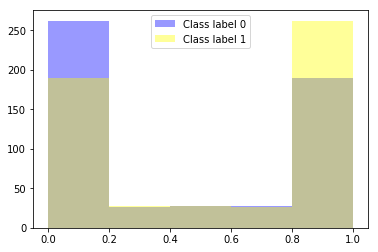

In [291]:
print("Probability distribution LSTM predictions:")
plot_histogram(prediction_simple_lstm)

# Training on dw data and predicting geo data using LSTM network(Accuracy = 50.47%)

In [31]:
# Splitting dataset into train and test corpus
X_train,y_train,X_test,y_test = split_data(dw_data,dw_labels,geo_data,geo_labels)

Shape of Corpus1 data tensor: (7814, 50)
Shape of Corpus1 label tensor: (7814, 2)
Shape of Corpus2 data tensor: (2130, 50)
Shape of Corpus2 label tensor: (2130, 2)


In [ ]:
# Un-comment the below mentioned code to train your model

"""# Configuring the neural network
model_lstm  = Sequential()
model_lstm.add(Embedding(vocabulary_size, 100, input_length=50))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(y_train.shape[1], activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print("model fitting - LSTM network")
model_lstm.summary()
# Training the model
model_lstm.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10)
# Saving the model
model_lstm.save("split_simple_dw_geo_lstm.h5")"""

In [32]:
# Loading the pre-trained model
model_lstm = load_model("split_simple_dw_geo_lstm.h5")

# Checking the accuracy
accuracy_model_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (accuracy_model_lstm[1]*100))

# Making predictions in terms of probabilities for each class
prediction_simple_lstm = model_lstm.predict(X_test,batch_size=10,verbose=0)# Getting class prbabilities for every text in the corpus

class_0,class_1 = ([] for i in range(2))
for index,arrays in enumerate(prediction_simple_lstm):
    class_0.append(arrays[0])
    class_1.append(arrays[1])

Accuracy: 50.47%


In [ ]:
print("Probability distribution LSTM predictions:")
plot_histogram(prediction_simple_lstm)

# Performing Transfer learning on Weebit pre-trained Deutsche learnen Corpus(Using LSTM network)

In [51]:
# Loading necessary libraries
dw_df = pd.read_hdf("dw.hdf5","text_df")[['text','y']]
# Dropping null values
dw_df.dropna(inplace=True)
# Converting class labels to int dtype
dw_df['y'] = dw_df['y'].astype(int)
print("Shape of the dataset:",dw_df.shape)
dw_df.head()

Shape of the dataset: (7814, 2)


,text,y
0,US-Präsident Barack Obama will bis zu 250 zusä...,1
1,US-Präsident Barack Obama wird an diesem Monta...,1
2,Die rechtspopulistische FPÖ hat bei der Bundes...,1
3,In Deutschland ist die Zahl der Flüchtlinge au...,1
4,Die beiden abgeschlagenen Präsidentschaftskand...,1


In [52]:
# Because of the computational expenses, I am using the top 20000 unique words. 
# At first, the text is tokenized and then convert those into sequences. 
# I have kept 50 words to limit the number of words in each comment.
vocabulary_size = 20000

# Initializing Tokenizer from keras
tokenizer = Tokenizer(num_words= vocabulary_size)
# Fitting text on the tokenizer
tokenizer.fit_on_texts(dw_df['text'])
# Converting text to sequence
sequences = tokenizer.texts_to_sequences(dw_df['text'])

# Finding unique tokenizer
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Padding sequences to the length of MAX_SEQUENCE_LENGTH
data = pad_sequences(sequences, maxlen=50)
labels = dw_df['y']

Found 60833 unique tokens.


Visualizing the data

class labels from the corpora: [1 0]
Total no of sentences in the Corpora is 7349
No of sentences in class label 1 is 6753
No of sentences in class label 0 is 1061


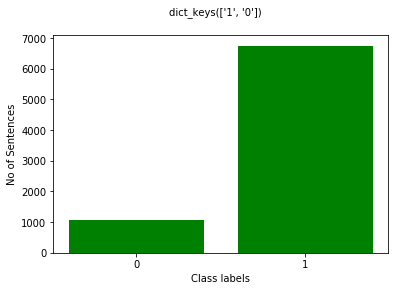

In [53]:
unique_class_labels = dw_df['y'].unique()
print("class labels from the corpora:",unique_class_labels)

# Used to modify elements of a dictionary
class make_dict(dict):
    def __getitem__(self, item):
        try:
            return dict.__getitem__(self, item)
        except KeyError:
            value = self[item] = type(self)()
            return value

# Printing the total number of sentences in the corpora
print("Total no of sentences in the Corpora is",df.shape[0])
# Getting count of sentences for every class
count_list = []
for class_label in dw_df['y'].unique():
    print("No of sentences in class label",str(class_label) + " is " + str(dw_df[dw_df['y']==class_label].shape[0]))
    count_list.append((str(class_label),int(dw_df[dw_df['y']==class_label].shape[0])))

# Getting data into dictionary for plotting
no_of_sentence = make_dict()
for values in count_list:
    no_of_sentence[values[0]] = values[1]

plt.bar(list(no_of_sentence.keys()), no_of_sentence.values(), color='g')
plt.suptitle(no_of_sentence.keys(), fontsize=10)
plt.xlabel('Class labels', fontsize=10)
plt.ylabel('No of Sentences', fontsize=10)
plt.show()

Splitting the training and testing data

In [54]:
# Getting the labels and features data
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Getting the splitting index for training and testing data
SPLIT_RATIO = 0.25
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
validation_samples = int(SPLIT_RATIO * data.shape[0])

# Getting the testing and training dataset
X_train = data[:-validation_samples]
y_train = labels[:-validation_samples]
X_test = data[-validation_samples:]
y_test = labels[-validation_samples:]

Shape of data tensor: (7814, 50)
Shape of label tensor: (7814, 2)


Training LSTM model on Deutche lernen corpus

In [106]:
vocabulary_size = 20000
# Configuring the neural network
model_transfer = Sequential()
model_transfer.add(Embedding(vocabulary_size, 100, input_length=50, weights=[np.array(model_lstm_weights[0])], trainable=True))
model_transfer.add(Dropout(0.2))
model_transfer.add(Conv1D(64, 5, activation='relu'))
model_transfer.add(MaxPooling1D(pool_size=4))
model_transfer.add(LSTM(100))
model_transfer.add(Dense(2, activation='softmax'))
model_transfer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("model fitting - CNN-LSTM convolutional neural network with globe word embeddings")
model_transfer.summary()
# Training the model
model_transfer.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=10)
# Saving the model
model_transfer.save("lstm_cnn_transfer.h5")

model fitting - CNN-LSTM convolutional neural network with globe word embeddings
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 46, 64)            32064     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 202       
Total params: 2,098,266
Trainable params: 2,098,266
Non-train

In [107]:
# Loading the pre-trained model
model_transfer = load_model("lstm_cnn_transfer.h5")

In [108]:
# Checking the accuracy
accuracy_transfer_lstm_cnn = model_transfer.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (accuracy_transfer_lstm_cnn[1]*100))

Accuracy: 96.67%


In [109]:
# Making predictions in terms of probabilities for each class
prediction_model_transfer = model_transfer.predict(X_test,batch_size=10,verbose=0)

In [110]:
prediction_model_transfer

array([[1.0169004e-04, 9.9989831e-01],
       [2.8252684e-02, 9.7174734e-01],
       [8.2518528e-07, 9.9999917e-01],
       ...,
       [1.1015429e-06, 9.9999893e-01],
       [4.7569301e-06, 9.9999523e-01],
       [3.0246863e-06, 9.9999702e-01]], dtype=float32)